In [1]:
import os
import numpy as np
import pickle
import rasterio
from collections import Counter
import json

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_grid_nums(home, country, source):
    cur_path = os.path.join(home, country, source)
    files = [os.path.join(cur_path, f) for f in os.listdir(cur_path) if f.endswith('.npy')]
    grid_numbers = [f.split('_')[-1].replace('.npy', '') for f in files]
    grid_numbers.sort()
    return grid_numbers

In [4]:
home = '/home/data'

s1_grid_numbers = get_grid_nums(home, 'Ghana', 's1_64x64_npy')
s2_grid_numbers = get_grid_nums(home, 'Ghana', 's2_64x64_npy')

s1_grid_numbers.sort()

only_in_one = []
all_grid_nums = set(s1_grid_numbers + s2_grid_numbers)
for grid_num in all_grid_nums:
    if grid_num not in s1_grid_numbers or grid_num not in s2_grid_numbers:
        only_in_one.append(grid_num)
        
print(only_in_one)

['025595', '025575', '025593', '025596']


In [9]:
s2_grid_numbers.sort()
print(s1_grid_numbers)

['000000', '000002', '000003', '000005', '000007', '000042', '000043', '000047', '000048', '000055', '000056', '000058', '000065', '000066', '000067', '000068', '000070', '000073', '000103', '000105', '000107', '000168', '000175', '000177', '000185', '000186', '000188', '000195', '000197', '000201', '000220', '000232', '000233', '000235', '000237', '000238', '000242', '000243', '000244', '000247', '000280', '000282', '000285', '000286', '000290', '000291', '000296', '000299', '000300', '000303', '000306', '000307', '000308', '000322', '000326', '000338', '000355', '000360', '000365', '000366', '000368', '000369', '000373', '000376', '000380', '000420', '000430', '000443', '000450', '000452', '000453', '000470', '000471', '000476', '000478', '000479', '000495', '000496', '000508', '000513', '000514', '000530', '000535', '000537', '000545', '000546', '000548', '000556', '000565', '000586', '000605', '000608', '000620', '000621', '000623', '000624', '000628', '000640', '000641', '000660',

In [2]:
def get_empty_grids(home, countries, sources, verbose):
    """
    Provides data from input .tif files depending on function input parameters. 
    
    Args:
      home - (str) the base directory of data

      countries - (list of str) list of strings that point to the directory names
                  of the different countries (i.e. ['Ghana', 'Tanzania', 'SouthSudan'])

      verbose - (boolean) prints outputs from function

    """

    mask_pixels_list = []
    empty_masks = []
    for country in countries:
        mask_fnames = [os.path.join(home, country, 'raster_64x64', f) for f in os.listdir(os.path.join(home, country, 'raster_64x64')) if f.endswith('.tif')]
        mask_ids = [f.split('_')[-1].replace('.tif', '') for f in mask_fnames]

        mask_fnames.sort()
        mask_ids.sort()

        assert len(mask_fnames) == len(mask_ids)

        for mask_fname, mask_id in zip(mask_fnames, mask_ids):
            with rasterio.open(mask_fname) as src:
                cur_mask = src.read()
                valid_pixels = np.sum(cur_mask > 0)
                mask_pixels_list.append((mask_id, valid_pixels))
                if valid_pixels == 0:
                    empty_masks.append(mask_id)

        for source in sources:
            cur_path = os.path.join(home, country, source)
            files = [os.path.join(cur_path, f) for f in os.listdir(cur_path) if f.endswith('.tif')]
            grid_numbers = [f.split('_')[-2] for f in files]
            grid_numbers.sort()

        delete_me = []
        all_ids = set(empty_masks + grid_numbers)
        for el in all_ids:
            if el in empty_masks and el in grid_numbers:
                delete_me.append(el)

        delete_me.sort()

        print('valid pixels list: ', len(mask_pixels_list))
        print('empty masks: ', len(empty_masks))
        print('delete me: ', len(delete_me))
        print('delete me: ', delete_me)
        
    return mask_pixels_list


In [4]:
home = '/home/data'
countries = ['Ghana']
sources = ['s2_64x64']
verbose = 1

mask_pixels_list = get_empty_grids(home, countries, sources, verbose)

print('--------------------------')

home = '/home/data'
countries = ['Ghana']
sources = ['s1_64x64']
verbose = 1

mask_pixels_list = get_empty_grids(home, countries, sources, verbose)

valid pixels list:  7569
empty masks:  3529
delete me:  32
delete me:  ['000001', '000004', '000008', '000011', '000013', '000044', '000069', '000072', '000102', '000117', '000157', '000159', '000167', '000172', '000173', '000176', '000178', '000179', '000187', '000189', '001754', '001792', '001793', '001797', '004429', '004441', '004451', '004501', '004506', '004508', '004511', '004514']
--------------------------
valid pixels list:  7569
empty masks:  3529
delete me:  45
delete me:  ['000001', '000004', '000008', '000011', '000013', '000044', '000069', '000072', '000102', '000117', '000157', '000159', '000167', '000172', '000173', '000176', '000178', '000179', '000187', '000189', '000198', '000203', '000216', '004429', '004441', '004451', '004501', '004506', '004508', '004511', '004514', '004529', '004588', '004926', '004929', '004941', '004961', '004962', '004963', '004964', '004966', '004967', '004968', '004969', '004977']


In [22]:
mask_pixels_arr = np.array(mask_pixels_list)
mask_pixels_arr.shape

(7569, 2)

In [23]:
mask_pix_sub = mask_pixels_arr[:,1].astype(int)
mask_pix_sub = mask_pix_sub[mask_pix_sub != 0]
mask_pix_sub.shape

(4040,)

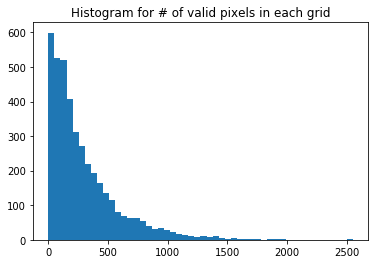

In [24]:
plt.hist(mask_pix_sub, bins=50) 
plt.title("Histogram for # of valid pixels in each grid")
plt.show()

In [14]:
valid_pix_numbers = mask_pixels_arr[:,1].astype(int)
print('Less than 10 pixels: ', np.sum((valid_pix_numbers < 10) * (valid_pix_numbers > 0)))
print('Less than 20 pixels: ', np.sum((valid_pix_numbers < 20) * (valid_pix_numbers > 0)))
print('Less than 30 pixels: ', np.sum((valid_pix_numbers < 30) * (valid_pix_numbers > 0)))
print('Less than 40 pixels: ', np.sum((valid_pix_numbers < 40) * (valid_pix_numbers > 0)))
print('Less than 50 pixels: ', np.sum((valid_pix_numbers < 50) * (valid_pix_numbers > 0)))
print('Less than 100 pixels: ', np.sum((valid_pix_numbers < 100) * (valid_pix_numbers > 0)))

Less than 10 pixels:  138
Less than 20 pixels:  267
Less than 30 pixels:  363
Less than 40 pixels:  459
Less than 50 pixels:  582
Less than 100 pixels:  1094
